In [55]:
import pandas as pd

In [56]:
df =pd.read_csv('/content/drive/MyDrive/online_retail.csv')

# EDA

In [57]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [58]:
df.shape

(541909, 8)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [60]:
df.duplicated().value_counts()

,count
False,536641
True,5268


In [61]:
# removing duplicate rows

df.drop_duplicates(inplace=True)

In [62]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135037
Country,0


In [63]:
#dropping the rows with nulls

df.dropna(subset=['CustomerID'], inplace =True)

In [64]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [65]:
# check for negative Quantity and UnitPrice

print(df[df['UnitPrice']<0].head())

print(df[df['Quantity']<0].head())

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []
    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

             InvoiceDate  UnitPrice  CustomerID         Country  
141  2022-12-01 09:41:00      27.50     14527.0  United Kingdom  
154  2022-12-01 09:49:00       4.65     15311.0  United Kingdom  
235  2022-12-01 10:24:00       1.65     17548.0  United Kingdom  
236  2022-12-01 10:24:00       0.29     17548.0  United Kingdom  
237  2022-12-01 10:24:00       0.29     17548.0  United Kingdom  


In [66]:
# dropping rows with negative quantity

df.drop(df[df['UnitPrice']<0].index, inplace=True)

In [67]:
df.shape

(401604, 8)

In [68]:
# Remove cancelled orders

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [69]:
df.shape

(392732, 8)

In [70]:
# converting InvoiceDate column to datetime

df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

# Feature Engineering

In [71]:
df['TotalPrice'] = df['Quantity']* df['UnitPrice']

In [72]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [50]:
# Recency, frequency and monetary calculation

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

In [51]:
# Rename columns

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


# Customer Segmentation

Customer segmentation is the process of dividing a company’s customer base into distinct groups based on shared characteristics such as behavior, demographics, spending patterns, or engagement levels. One popular method is RFM segmentation, which groups customers based on:

1. Recency – How recently a customer made a purchase

2. Frequency – How often they purchase

3. Monetary – How much money they spend


**Why is Customer Segmentation Needed?**

**1. Personalized Marketing**

Tailor messages and offers to each group, improving customer experience and response rates.

**2. Resource Optimization**

Focus efforts and budget on high-value segments like Champions or Loyal customers, rather than treating all customers the same.

**3. Customer Retention**

Identify and re-engage at-risk segments like Hibernating or Lost customers through targeted strategies.

**4. Better Product & Service Development**

Understand what each segment values most, helping design more relevant offerings to them.

**5. Improved Business Strategy**

Segments provide clear insights for sales forecasting, campaign planning, and business growth decisions.



In [54]:
# scale data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
!cp scaler.pkl /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


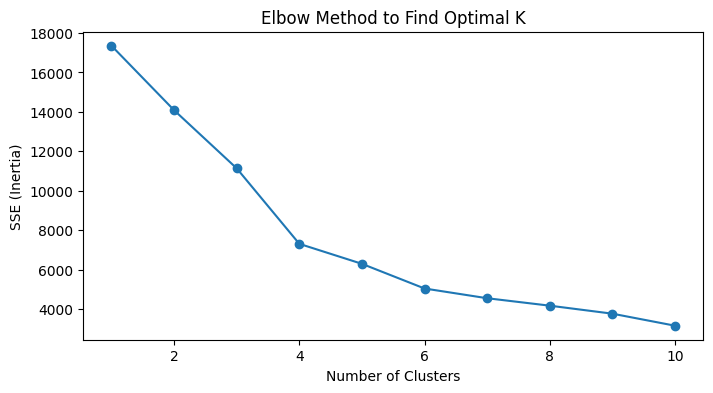

In [53]:
# elbow method to find optimal cluster

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method to Find Optimal K')
plt.show()


The optimal number of clusters is 4.

# K-Means Algorithm

In [23]:
# k-means for 4 clusters

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [24]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,2
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,2


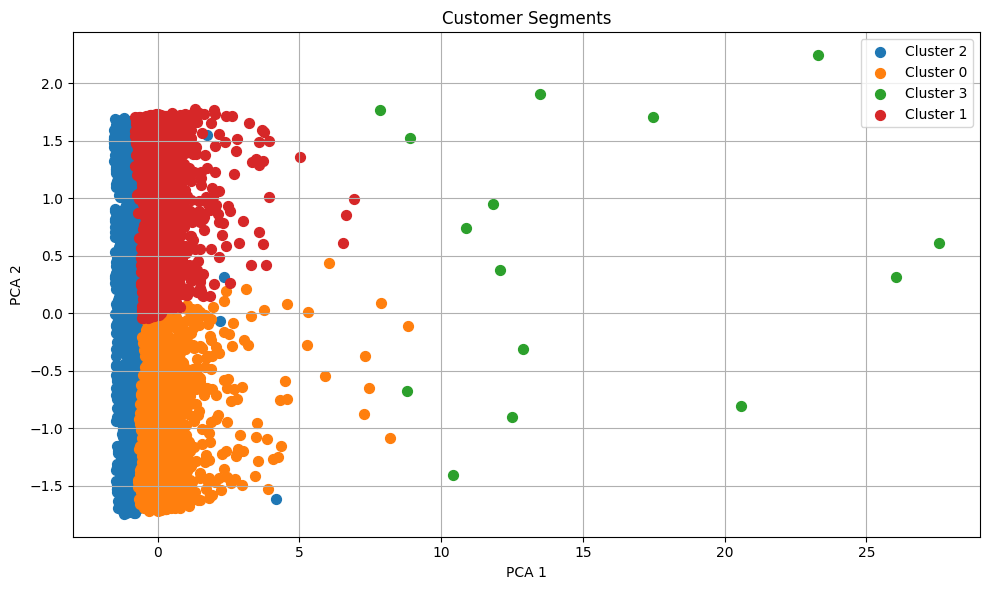

In [25]:
# visualizing clusters using PCA

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Add PCA components to the DataFrame
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
for cluster in rfm['Cluster'].unique():
    subset = rfm[rfm['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', s=50)

plt.title('Customer Segments')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Average RFM values per cluster

rfm_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
rfm_summary['Count'] = rfm['Cluster'].value_counts().sort_index()
rfm_summary


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,44.5,5.0,2209.7,1671
1,47.1,4.5,1660.3,1695
2,257.9,1.5,630.0,958
3,6.7,78.0,118466.2,15


From the above summary, we can conclude:

**1. Cluster 3 (VIPs):**

With the lowest recency (6.7), extremely high frequency (78.0), and an exceptionally high monetary value (118466.2), these 15 customers are the most valuable and highly engaged top-tier customers.

**2. Cluster 1 (Occasional):**

They purchase often (4.5 frequency), spend well (1660.3), and have recent activity (47.1 days). They are occasional customers.

**3. Cluster 0 (Loyal Customers):**

These are consistent spending customers(2209.7) with constant engagement. Recency of 44.5 and frequency of 5.0 indicate loyal customers.

**4. Cluster 2 (Hibernating/Lost):**

These are high recency (257.9 days) with low frequency (1.5) and low monetary value (630.0) customers. They are inactive customers. Need to consider reactivation strategies or feedback campaigns.

In [27]:
# naming the customers based on their buying pattern

def map_cluster_to_segment(cluster):
    if cluster == 2:
        return "Lost"
    elif cluster == 0:
        return "Loyal"
    elif cluster == 1:
        return "Ocassional"
    elif cluster == 3:
        return "VIP"

# Create the new column
rfm['Customer_Segment'] = rfm['Cluster'].map(map_cluster_to_segment)


In [28]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,Customer_Segment
0,12346.0,326,1,77183.60,2,4.158708,-1.616371,Lost
1,12347.0,2,7,4310.00,0,0.791212,-1.694407,Loyal
2,12348.0,75,4,1797.24,0,0.074130,-1.713523,Loyal
3,12349.0,19,1,1757.55,0,0.021447,-1.716962,Loyal
4,12350.0,310,1,334.40,2,-1.185076,-1.744607,Lost


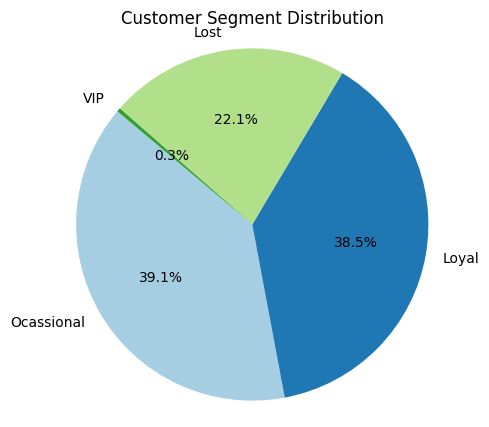

In [29]:
import matplotlib.pyplot as plt

# number of customers in each segment
segment_counts = rfm['Customer_Segment'].value_counts()

# Plot  pie chart
plt.figure(figsize=(5,5))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Customer Segment Distribution")
plt.axis('equal')
plt.show()


1. Occasional Customers make up the largest segment (≈39%), indicating a strong base of repeat buyers who engage regularly.

2. Loyal customers are a close second (≈38.5%), representing high-value, frequent, and recent customers—ideal targets for retention and referral programs.

3. Lost or Hibernating Customers contribute for about 22.1%, suggesting room for re-engagement campaigns to reactivate this segment.

4. VIP Customers are a very very small group (≈0.3%) but likely contribute disproportionately high revenue—consider exclusive offers to retain them.

The healthy share of loyal and occasional customers reflects a well-retained base, but there's potential to revive and upsell the less active users.

In [30]:
# saving the k- means model for later use

import pickle

with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
!cp kmeans_model.pkl /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DBSACN Algorithm

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns


# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


ValueError: could not convert string to float: 'Lost'

In [ ]:
# K-distance plot to find good eps

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

n = NearestNeighbors(n_neighbors=5)
nbrs = n.fit(rfm_scaled)
distances, indices = nbrs.kneighbors(rfm_scaled)
distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.title("K-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("5-NN distance")
plt.grid()
plt.show()


In [ ]:
# Apply DBSCAN

dbscan = DBSCAN(eps=1.8, min_samples=3)
rfm['Cluster_db'] = dbscan.fit_predict(rfm_scaled)


In [ ]:
rfm.groupby('Cluster_db').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
})


In [ ]:
# Visualize the clusters (Recency vs Monetary)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster_db', palette='Set1')
plt.title('DBSCAN Customer Segments')
plt.show()


# Recommendation System

A Recommendation System in e-commerce is a tool that suggests products or services to users based on their browsing history, past purchases, ratings, or behavior. It’s like a personalized system that helps users discover items they are likely to buy.

Common types of recommendation systems include:

Collaborative Filtering: Recommends items based on what similar users liked

Content-Based Filtering: Suggests items similar to what the user liked before

Hybrid Models: Combine both methods for better recommendations


**Why Recommendation System is Needed in E-commerce?**

**1. Personalized Shopping Experience**

It makes users feel understood by showing products that match their interests.

**2.Increased Sales and Revenue**

Recommending relevant items boosts upselling and cross-selling opportunities.

**3. Better Customer Engagement**

Keeps users browsing longer and coming back for more.

**4. Efficient Product Discovery**

Helps users navigate large catalogs quickly and find what they need.

**5. Data-Driven Decisions**

Uses customer behavior data to fine-tune marketing and product strategies.






In [ ]:
df

In [35]:
# creating a pivot table

user_item_matrix = df.pivot_table(index="CustomerID", columns="Description", values="TotalPrice", aggfunc='sum')
user_item_matrix.fillna(0, inplace=True)


In [90]:
user_item_matrix

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,16.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18282.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**User-user collaborative filtering**

User-user collaborative filtering method recommends products to a user by finding similar users.

It looks at how users have rated or interacted with items, and suggests items liked by users who behave like the target user.

In [37]:
# user-user collaborative filtering

from sklearn.metrics.pairwise import cosine_similarity

# Compute user similarity
user_similarity = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)



In [38]:
   def predict_user_user(product_name, top_n=5):
    if product_name not in user_item_matrix.columns:
        return None

    users_who_bought = user_item_matrix[user_item_matrix[product_name] > 0].index


    similar_users = user_sim_df.loc[users_who_bought].mean(axis=0).sort_values(ascending=False)

    similar_users = similar_users.drop(users_who_bought, errors='ignore')
    top_similar_users = similar_users.head(10).index

    recommended_products = user_item_matrix.loc[top_similar_users].mean(axis=0)


    recommended_products = recommended_products.drop(product_name, errors='ignore')

    return recommended_products.sort_values(ascending=False).head(top_n).reset_index().rename(
        columns={0: "Score", "index": "Product Description"})


**Item-Item Collaborative filtering**

In Item-item collaborative filtering, recommendations are based on the similarity between items.

It checks what other items are often liked together and suggests those.



In [39]:
# Compute item similarity

item_similarity = cosine_similarity(user_item_matrix.T)
item_sim_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)


In [40]:
def predict_item_item(product_name, top_n=5):
    if product_name not in item_sim_df.columns:
        return None

    similar_items = item_sim_df[product_name].sort_values(ascending=False).drop(index=product_name)
    return similar_items.head(top_n).reset_index().rename(
        columns={product_name: "Similarity Score", "index": "Product Description"})

In [87]:
def recommend_top_n(product_name, n=5, method='item'):
    predictions = {}

    if product_name not in user_item_matrix.columns:
        return None

    if method == 'item':
        # Item-Item recommendation
        sim_scores = item_sim_df[product_name].drop(index=product_name)
        top_n = sim_scores.sort_values(ascending=False).head(n)
        return pd.DataFrame(top_n).reset_index().rename(
            columns={product_name: "Predicted Interest Score", "index": "Product Description"}
        )

    elif method == 'user':
        # User-User recommendation
        users_who_bought = user_item_matrix[user_item_matrix[product_name] > 0].index
        if len(users_who_bought) == 0:
            return None

        similar_users = user_sim_df.loc[users_who_bought].mean(axis=0)
        similar_users = similar_users.drop(users_who_bought, errors='ignore')
        top_similar_users = similar_users.sort_values(ascending=False).head(10).index

        # Aggregate item scores from similar users
        avg_ratings = user_item_matrix.loc[top_similar_users].mean(axis=0)

        avg_ratings = avg_ratings.drop(index=product_name, errors='ignore')

        top_n = avg_ratings.sort_values(ascending=False).head(n)
        return pd.DataFrame(top_n).reset_index().rename(
            columns={0: "Predicted Interest Score", "index": "Product Description"}
        )
    else:
        raise ValueError("Method must be 'item' or 'user'")



In [88]:
# check for a user similarity

recommend_top_n("WHITE HANGING HEART T-LIGHT HOLDER", n=5, method='user')

,Description,Predicted Interest Score
0,SPOTTY BUNTING,160.875
1,ASSORTED COLOUR BIRD ORNAMENT,128.440
2,PARTY BUNTING,116.370
3,REGENCY CAKESTAND 3 TIER,113.145
4,JUMBO BAG RED RETROSPOT,89.973


In [89]:
# check for an item similarity

recommend_top_n("WHITE HANGING HEART T-LIGHT HOLDER", n=5, method='item')


,Description,Predicted Interest Score
0,GIN + TONIC DIET METAL SIGN,0.763539
1,RED HANGING HEART T-LIGHT HOLDER,0.741223
2,WASHROOM METAL SIGN,0.728206
3,LAUNDRY 15C METAL SIGN,0.727322
4,GREEN VINTAGE SPOT BEAKER,0.719897


In [91]:
import pickle

# Save user-item matrix
with open('user_item_matrix.pkl', 'wb') as f:
    pickle.dump(user_item_matrix, f)

# Save user similarity matrix
with open('user_sim_df.pkl', 'wb') as f:
    pickle.dump(user_sim_df, f)

# Save item similarity matrix
with open('item_sim_df.pkl', 'wb') as f:
    pickle.dump(item_sim_df, f)

In [92]:
from google.colab import drive
drive.mount('/content/drive')

# save files to Drive
!cp user_item_matrix.pkl /content/drive/MyDrive/
!cp user_sim_df.pkl /content/drive/MyDrive/
!cp item_sim_df.pkl /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
